In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/NNLP
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/NNLP
 assignment22.ipynb
 assignment2.ipynb
 assignment3.ipynb
 assignment4.ipynb
 classifier_doc_embeddings.py
 classifier_ffnn.py
 classifier_lr.py
 classifier_word_embeddings.py
 comments.tsv
'Copy of 01_seminar_starter.ipynb'
'Copy of sem_28_11.ipynb'
 d2v.model
 elmo_2x2048_256_2048cnn_1xhighway_options.json
 elmo_2x2048_256_2048cnn_1xhighway_weights.hdf5
 file2_ff.tsv
 file2.tsv
 file3.tsv
 file_ll.tsv
 file_l.ts

In [2]:
!pip install transformers==2.1.1 
!pip install tensorboard==1.9
# !pip install pytorch_pretrained_bert


     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 860kB 52.2MB/s 
     |████████████████████████████████| 1.0MB 41.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=d7a88aec061efd44a84c14c7f7b8e73983ebcaf4ced659f372d14726605bed40
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
     |████████████████████████████████| 3.3MB 1.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.9.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [3]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig#,BertForSequenceClassification
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter, defaultdict
import codecs
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string
from time import time
import string 
%matplotlib inline
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from transformers import BertTokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 5740012.36B/s]


In [0]:
translator = str.maketrans('', '', string.punctuation)

def surround_non_symbols(word):
    new_word=''
    list_letters=list(word)    
    for symbol in list_letters:
        if symbol in set(string.punctuation):
            symbol=' '+symbol+' '
        else:
            symbol=symbol
        new_word+=symbol
    return new_word
    

def preprocess_text(Text,punct=False,figures=False):
    result=[]
    for sentense in Text:
        string=(sentense.lower())
        string = " ".join([surround_non_symbols(word) for word in string.split()])
        clear_sentence=" ".join(string.split())
        if punct==True:
            clear_sentence=clear_sentence.translate(translator)
        if figures==True:
            clear_sentence=re.sub(r'\d+', '', clear_sentence)
        result.append(clear_sentence)
    return result

def tokenization(data):
    data_tok =[line.split() for line in tqdm(data)]
    return data_tok

def text_readers(path):
    file=codecs.open(path,'r','utf_8_sig')
    text=file.read()
    file.close()
    text=text.split('\n')
    text=text[:-1]
    return text

train_labels=pd.read_csv('FILIMDB/train.labels',header=None)
dev_labels=pd.read_csv('FILIMDB/dev.labels',header=None)
dev_labels_b=pd.read_csv('FILIMDB/dev-b.labels',header=None)

train_text=text_readers('FILIMDB/train.texts')
dev=text_readers('FILIMDB/dev.texts')
test=text_readers('FILIMDB/test.texts')
dev_b=text_readers('FILIMDB/dev-b.texts')
test_b=text_readers('FILIMDB/test-b.texts')

In [0]:
train_tokens=preprocess_text(train_text)

In [7]:
bert_tokens=tokenizer.tokenize(train_tokens[0])
bert_tokens_subtoken_idxs = tokenizer.convert_tokens_to_ids(bert_tokens)

In [0]:
#mask creation
def bpe_tokenize(bpe_tokenizer, words):
    new_words = []
    bpe_masks = []
    pad_token = '[PAD]'
    toks=bpe_tokenizer.tokenize(words)
    if len(toks)<512:
      pad_size=512-len(toks)
      toks=toks+pad_size*[pad_token]
    for word in toks:
        bpe_tokens = bpe_tokenizer.tokenize(word)
        new_words += bpe_tokens        
        bpe_masks += [1] + [0] * (len(bpe_tokens) - 1)

    return new_words, bpe_masks

In [0]:
tokens,masks=bpe_tokenize(tokenizer,train_text[1])


In [0]:

def vectorize_ex( texts, label):
    label_id=[1 if label == 'pos' else 0 ]
    sep_token = '[SEP]'
    cls_token = '[CLS]'
    pad_token = '[PAD]'

    sep_vid = tokenizer.vocab[sep_token]
    cls_vid = tokenizer.vocab[cls_token]
    pad_vid = tokenizer.vocab[pad_token]



    tokens,mask=bpe_tokenize(tokenizer,texts)
    tokens=tokens[:512]
    mask=mask[:512]
  
 

    src_txt = [' '.join(sent) for sent in [tokens]]
    text = ' {} {} '.format(sep_token, cls_token).join(src_txt)

    src_subtokens = tokenizer.tokenize(text)

    src_subtokens = [cls_token] + src_subtokens + [sep_token]
    src_subtokens=src_subtokens[:511]+ [sep_token]
    subtoken_idxs = tokenizer.convert_tokens_to_ids(src_subtokens)
    _segs = [-1] + [i for i, t in enumerate(subtoken_idxs) if t == sep_vid]
    segs = [_segs[i] - _segs[i - 1] for i in range(1, len(_segs))]
    segments_ids = []
    for i, s in enumerate(segs):
        if (i % 2 == 0):
            segments_ids += s * [0]
        else:
            segments_ids += s * [1]


    return subtoken_idxs, segments_ids, mask[:512], label_id

answers on questions:

a) we and such tokens  '[SEP]','[CLS]','[PAD]'. sep set in begin of sentences, cls in the end

b)length of  positional embeddings is 512




In [0]:
train_labels_list=list(train_labels[0])
subtoken_idxs, segments_ids, mask, label_id=vectorize_ex(train_text[0],train_labels_list[1])

In [0]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm

In [0]:
subtoken_idxs_all=[]
segments_ids_all=[]
mask_all=[]
label_id_all=[]
for i in (range(len(train_text))):
  subtoken_idxs, segments_ids, mask, label_id=vectorize_ex(train_text[i],train_labels_list[i])
  subtoken_idxs_all.append(subtoken_idxs)
  segments_ids_all.append(segments_ids)
  mask_all.append(mask)
  label_id_all.append(label_id)

In [0]:
subtoken_idxs_all_=torch.tensor(subtoken_idxs_all)
mask_all_=torch.tensor(mask_all)
segments_ids_all_=torch.tensor(segments_ids_all)
label_id_all_=torch.tensor(label_id_all)



In [0]:
train_data = TensorDataset(subtoken_idxs_all_, mask_all_, label_id_all_)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=4)

In [0]:
bert = BertModel.from_pretrained('bert-base-uncased')

class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens,mask):
        _, pooled_output = self.bert(tokens,attention_mask=mask)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return proba

In [0]:
bert_clf = BertBinaryClassifier().cuda()

optimizer = optim.Adam(bert_clf.parameters(), lr=3e-6)
loss_func = nn.BCEWithLogitsLoss()

In [0]:
from sklearn.metrics import accuracy_score

In [70]:
accuracy_tot=[]
loss_tot=[]
for epoch_num in range(2):
    bert_clf.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for ids,mask,lab in tqdm(train_dataloader):
        # token_ids, labels = tuple(t.to(device) for t in batch_data)
        ids=ids.cuda()
        mask=mask.cuda()
        lab=lab.cuda()
        probas = bert_clf(ids,mask)
        loss_func = nn.BCELoss()
        
        batch_loss = loss_func(probas, lab.float())
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
        acc=accuracy_score(probas.detach().cpu().numpy().round(),lab.detach().cpu().numpy())
        loss_epoch.append(batch_loss.detach().cpu().numpy())
        accuracy_epoch.append(acc)
    bert_clf.train(False)
    accuracy_tot.append(np.mean(accuracy_epoch))
    loss_tot.append(np.mean(loss_epoch))
    print(accuracy_tot[-1])

        

  0%|          | 0/3750 [00:00<?, ?it/s]

0.8514


100%|██████████| 3750/3750 [17:31<00:00,  3.56it/s]

0.928


Text(0.5, 1.0, 'loss')

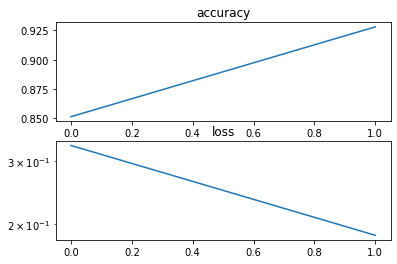

In [74]:
plt.subplot(211)
plt.plot(accuracy_tot)
plt.title('accuracy')
plt.subplot(221)
plt.semilogy(loss_tot)
plt.title('loss')

In [0]:
def bert_features(text,labels_list): 
  subtoken_idxs_all=[]
  segments_ids_all=[]
  mask_all=[]
  label_id_all=[]
  for i in (range(len(text))):
    subtoken_idxs, segments_ids, mask, label_id=vectorize_ex(text[i],labels_list[i])
    subtoken_idxs_all.append(subtoken_idxs)
    segments_ids_all.append(segments_ids)
    mask_all.append(mask)
    label_id_all.append(label_id)
  return subtoken_idxs_all,segments_ids_all,mask_all,label_id_all
dev_labels_list=dev_labels[0].tolist()
dev_labels_b_list=dev_labels_b[0].tolist()

In [0]:
#make bert tokens for dev and dev_b
subtoken_idxs_all_dev,segments_ids_all_dev,mask_all_dev,label_id_all_dev=bert_features(dev,dev_labels_list)
subtoken_idxs_all_dev_b,segments_ids_all_dev_b,mask_all_dev_b,label_id_all_dev_b=bert_features(dev_b,dev_labels_b_list)

In [0]:
def predict(model,subtoken_idxs_all,mask_all,segments_ids_all):
  subtoken_idxs_all_=torch.tensor(subtoken_idxs_all)
  mask_all_=torch.tensor(mask_all)
  segments_ids_all_=torch.tensor(segments_ids_all)
  # label_id_all_=torch.tensor(label_id_all)

  train_data = TensorDataset(subtoken_idxs_all_, mask_all_)
  
  train_dataloader = DataLoader(train_data, batch_size=4)
  model.eval()
  preds=[]
  for ids,mask in tqdm(train_dataloader):
    # token_ids, labels = tuple(t.to(device) for t in batch_data)
    ids=ids.cuda()
    mask=mask.cuda()
    # lab=lab.cuda()
    probas = model(ids,mask)
    preds.append(probas.detach().cpu().numpy().round())
  preds=np.concatenate(preds)
  return preds



In [104]:
y_pred_train=predict(bert_clf,subtoken_idxs_all,mask_all,segments_ids_all)
y_pred_train_dev=predict(bert_clf,subtoken_idxs_all_dev,mask_all_dev,segments_ids_all_dev)
y_pred_train_dev_b=predict(bert_clf,subtoken_idxs_all_dev_b,mask_all_dev_b,segments_ids_all_dev_b)

100%|██████████| 500/500 [00:39<00:00, 12.52it/s]


In [0]:
train_labels_=train_labels[0].replace(['neg','pos'],[0,1])
dev_labels_=dev_labels[0].replace(['neg','pos'],[0,1])
dev_labels_b_=dev_labels_b[0].replace(['neg','pos'],[0,1])

In [106]:
print('train accuracy',accuracy_score(y_pred_train,train_labels_))
print('dev accuracy',accuracy_score(y_pred_train_dev,dev_labels_))
print('dev_v accuracy',accuracy_score(y_pred_train_dev_b,dev_labels_b_))

train accuracy 0.9606666666666667
dev accuracy 0.9071
dev_v accuracy 0.771


In [0]:
# functions for making bert tokens without labels
def vectorize_ex( texts):
   
    sep_token = '[SEP]'
    cls_token = '[CLS]'
    pad_token = '[PAD]'

    sep_vid = tokenizer.vocab[sep_token]
    cls_vid = tokenizer.vocab[cls_token]
    pad_vid = tokenizer.vocab[pad_token]



    tokens,mask=bpe_tokenize(tokenizer,texts)
    tokens=tokens[:512]
    mask=mask[:512]
  
 

    src_txt = [' '.join(sent) for sent in [tokens]]
    text = ' {} {} '.format(sep_token, cls_token).join(src_txt)

    src_subtokens = tokenizer.tokenize(text)

    src_subtokens = [cls_token] + src_subtokens + [sep_token]
    src_subtokens=src_subtokens[:511]+ [sep_token]
    subtoken_idxs = tokenizer.convert_tokens_to_ids(src_subtokens)
    _segs = [-1] + [i for i, t in enumerate(subtoken_idxs) if t == sep_vid]
    segs = [_segs[i] - _segs[i - 1] for i in range(1, len(_segs))]
    segments_ids = []
    for i, s in enumerate(segs):
        if (i % 2 == 0):
            segments_ids += s * [0]
        else:
            segments_ids += s * [1]


    return subtoken_idxs, segments_ids, mask

def bert_features_test(text): 
  subtoken_idxs_all=[]
  segments_ids_all=[]
  mask_all=[]
  
  for i in (range(len(text))):
    subtoken_idxs, segments_ids, mask=vectorize_ex(text[i])
    subtoken_idxs_all.append(subtoken_idxs)
    segments_ids_all.append(segments_ids)
    mask_all.append(mask)

  return subtoken_idxs_all,segments_ids_all,mask_all


In [118]:
subtoken_idxs_all_test,segments_ids_all_test,mask_all_test=bert_features_test(test)
subtoken_idxs_all_test_b,segments_ids_all_test_b,mask_all_test_b=bert_features_test(test_b)

y_pred_test=predict(bert_clf,subtoken_idxs_all_test,mask_all_test,segments_ids_all_test)
y_pred_train_test_b=predict(bert_clf,subtoken_idxs_all_test_b,mask_all_test_b,segments_ids_all_test_b)

100%|██████████| 2150/2150 [02:51<00:00, 12.93it/s]


In [119]:
def to_df(predictions):    
    dataframes=[]
    tokens=[train_text,dev,test,dev_b,test_b]
    names=['train/','dev/','test/','dev-b/','test-b/']
    for token,name,pred in tqdm(zip(tokens,names,predictions)):
        first_column=[]
        for i in range(len(token)):
            first_column.append(name+str(i))
        df = pd.DataFrame([first_column,pred]).T
        dataframes.append(df)
    result=pd.concat(dataframes,ignore_index=True) 
    result[1]=result[1].replace([0,1],['neg','pos'])
    return result
preds=[y_pred_train,y_pred_train_dev,y_pred_test,y_pred_train_dev_b,y_pred_train_test_b]
result=to_df(preds)
result.to_csv('file5.tsv',index=False,header=False,sep='\t')

5it [00:05,  1.10s/it]
